<table>
 <tr align=left><td><img align=left src="https://i.creativecommons.org/l/by/4.0/88x31.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

# Performance

We have not really paid much attention to performance of code beyond basic instruction counting up until now.  These lectures are dedicated to a deeper dive into these issues and what are some important things to keep in mind.

## Example: Matrix-Matrix Multiplication

To start our discussion let us consider the algorithm for matrix-matrix multiplication which algorithmically looks like
```
do i=1:N
    do j=1:N
        do k=1:N
            C[i, j] = C[i, j] + A[i, k] * B[k, j]
        end do
    end do
end do
```

Consider the follow approaches to this problem:
1. Matrix multiplication via a GCC (Fortran) intrinsic.
1. Straight forward three-loop multiplication
1. Parallelized double-loop using BLAS intrinsic
1. BLAS intrinsic

```fortran
real function matrix_multiply_test(N,method)

    use mod_rand
    implicit none
    
    external DGEMM,DDOT
    
    double precision :: DDOT
    integer, intent(in) :: N,method
    integer :: start,finish,count_rate
    double precision, dimension(:,:), allocatable :: A,B,C
    
    ! Local
    integer :: i,j,k
    
    ! Create the random arrays
    call init_random_seed()
    allocate(A(N,N),B(N,N),C(N,N))
    call random_number(A)
    call random_number(B)
    
    ! Start the timer and start multiplying
    call system_clock(start,count_rate)
    select case(method)
        case(1) ! Default method provided as an intrinsic method
            C = matmul(A,B)
        case(2) ! Simple three loop multiplication
            !$OMP parallel do private(j,k)
            do i=1,N
                do j=1,N
                    do k=1,N
                        C(i,j) = C(i,j) + A(i,k) * B(k,j)
                    enddo
                enddo
            enddo
        case(3) ! OpenMP parallelized double loop
            !$OMP parallel do private(j)
            do i=1,N
                do j=1,N
                    C(i,j) = DDOT(N, A(i,:), 1, B(:,j), 1)
                enddo
            enddo
        case(4) ! BLAS Routine call
            ! call DGEMM(transa,transb,l,n,m,alpha,a,lda,b,ldb,beta,c,ldc)
            call DGEMM('N', 'N', N, N, N, 1.d0, A, N, B, N, 0.d0, C, N)
        case default
            print *, "***ERROR*** Invalid multiplication method!"
            matrix_multiply_test = -1
            return
    end select
    call system_clock(finish,count_rate)
    
    matrix_multiply_test = float(finish - start) / float(count_rate)
    
end function matrix_multiply_test
    
program matrix_multiply
    
    use omp_lib

    implicit none
    
    integer :: N, method, threads
    character(len=10) :: input_N, input_method, input_threads
    real :: matrix_multiply_test, time
    
    select case(iargc())
        case(0)
            N = 1000
            method = 1
            threads = 1
        case(1)
            call getarg(1,input_N)
            read(input_N,'(I10)') N
            method = 1
        case(2)
            call getarg(1,input_N)
            call getarg(2,input_method)
            read(input_N,'(I10)') N
            read(input_method,'(I10)') method
        case(3)
            call getarg(1,input_N)
            call getarg(2,input_method)
            call getarg(3,input_threads)
            read(input_N,'(I10)') N
            read(input_method,'(I10)') method
            read(input_threads,'(I10)') threads
        case default
            print *, "***ERROR*** Too many arguments!"
            stop
    end select
    
    !$ call omp_set_num_threads(threads)

    time = matrix_multiply_test(N, method)
    
    print '("Timing for ",i5,"x",i5," matrices: ",f10.5," s")',N,N,time
    
end program matrix_multiply
```

#### Results

Based on $1000 \times 1000$ matrix-matrix multiply compiled with `gfortran` version 6.3.0 with the compile time flags `-O3 -funroll-loops -finline-functions -fdefault-real-8 -fopenmp`.


Method                           | No-Threads            | Threaded
---------------------------------|-----------------------|---------------------------
Default mat_mult function        |            35.79600 s |                36.19100 s
3 loop multiplication            |            39.24700 s |                10.04000 s                   
Double loop (internal BLAS)      |             6.80500 s |                 1.76600 s                   
BLAS Routine call                |             0.00300 s |                 0.00300 s                   


## Machine Architecture Considerations

Before we can talk about performance we need to understand a bit about modern computing architectures.  Note that this glossing over a lot of important details as we will focus on only the details that we will specifically deal with.

### Von Neumann Architecture
![image](./images/vonneumann_architecture.png)
*Kapooht - Wikipedia Commons*

### Instruction Pipeline
![image](./images/pipeline_1.png)
*Cburnett - Wikipedia Commons*

![image](./images/memory_architecture.png)

### Moore's Law

In 1965, Gordon Moore (co-founder of Intel) predicted that the transistor density (and hence the speed) of chips would double every 18 months for the forseeable future. This is know as Moore’s law This proved remarkably accurate for more than 40 years, see the graphs at. Note that doubling every 18 months means an increase by a factor of 4096 every 14 years.

### Is Moore's Law Doomed?
![image](./images/moores_law.png)
*Steve Jurvetson - Wikipedia Commons - https://www.flickr.com/photos/jurvetson/31409423572/*

### Current Performance Bottlenecks

 - Transistors can no longer be packed more densely in a single core
 - Memory is really the bottleneck
 - Hard limit due to the speed of light
 - Power consumption and therefore heat dissipation
 
### Solutions?
 - Many-core technologies
 - Memory hierarchies
 - Algorithms that take into account these limitations

![image](./images/memory_single_core.png)

![image](./images/pipeline_2.png)
*Cburnett - Wikipedia Commons*

### Roof-line Model
![image](./images/roofline.png)
*Giu.natale - Wikipedia Commons*

### Many-Core Architectures

![image](./images/kepler_arch.png)
![image](./images/kepler_smx.png)
*NVIDIA - Kepler GK110/210 White Paper - http://images.nvidia.com/content/pdf/tesla/NVIDIA-Kepler-GK110-GK210-Architecture-Whitepaper.pdf*

## Parallelization

Parallelization is one of the primary ways we can increase performance on today's computing architectures.  There are 2+1 major types of parallelization paradigms:
 - Shared memory - each pipeline can access the memory for the entire problem
 - Distributed memory - each pipeline can only access part of the memory for the entire problem
 - Hybrid parallelism - use both...

### Shared Memory

 - Basic construct is a *thread* - each thread has a pipeline and in the simplest case each core runs one thread
 - OpenMP, CUDA, OpenCL, OpenACC
 - Single nodes on a cluster, GPU, Xeon Phi, etc.

### Distributed Memory

 - Basic contruct is a *process* 
 - Each process is memory local but can communicate to other processes either on the same CPU or across a network
 - Each process can have multiple threads (hybrid parallelism)
 - MPI is most common
 - Clusters, super-computers, etc.

### Scalability

Measures of parallel performance:

 - Strong Scaling:  Execution time decreases inversely proportional to the number of processes
   - Fixed size problem
 - Weak Scaling: Execution time remains constant as problem size and processes number are increased proportionally
   - Variable size problem

### OpenMP

OpenMP is defined by a set of *directives* that are put into code which on compilation a compiler can turn into multi-threaded code.

Simple hello world from OpenMP.  Here we fetch the number of threads and print out the unique ID given to each.
```fortran
program hello_world_omp
    
    use omp_lib

    implicit none
    integer :: num_threads, thread_id

    !$OMP parallel private(num_threads, thread_id)
    !$ num_threads = omp_get_num_threads()
    !$ thread_id = omp_get_thread_num()
    print *, 'Hello from thread number', thread_id + 1, &
             ' of ', num_threads, ' processes'

    !$OMP end parallel

end program hello_world_omp

```

```fortran
program yeval
   
   use omp_lib

   implicit none

   integer(kind=8), parameter :: n = 2**16
   integer(kind=4) :: i, nthreads
   real(kind=8), dimension(n) :: y
   real(kind=8) :: dx, x

   ! Specify number of threads to use:
   !$ print *, "How many threads to use? "
   !$ read *, nthreads
   !$ call omp_set_num_threads(nthreads)
   !$ print "('Using OpenMP with ',i3,' threads')", nthreads

   dx = 1.d0 / (n+1.d0)

   !$omp parallel do private(x) 
   do i=1, n
      x = i * dx
      y(i) = exp(x) * cos(x) * sin(x) * sqrt(5.d0 * x + 6.d0)
   enddo
   !$omp end parallel do

   print *, "Filled vector y of length", n

end program yeval
```
*Modified from amath 583 - R.J. LeVeque - http://faculty.washington.edu/rjl/classes/am583s2014/notes/openmp.html*

#### Fine-Grain vs. Coarse-Grain Parallelism

Consider the problem of normalizing a vector which requires two steps:
1. Compute the norm of the vector, and
1. Divide each entry of the vector by the norm.

Unfortunately we need to loop over every entry in the vector to compute the norm **before** we can perform the division of each entry.  There are two ways to tackle this problem,
 - Let the compiler decide what thread takes what entries (fine grain) - large number of small tasks
 - Let the programmer explicitly control which entries are handled by each thread (coarse grain) - small number of large tasks

```fortran
program fine_grain
   
    use omp_lib
    implicit none
    integer :: i, thread_num
    integer, parameter :: n = 1000
 
    real(kind=8), dimension(n) :: x, y
    real(kind=8) :: norm,ynorm
 
    integer :: nthreads
    
    ! Specify number of threads to use:
    nthreads = 1       ! need this value in serial mode
    !$ nthreads = 4    
    !$ call omp_set_num_threads(nthreads)
    !$ print "('Using OpenMP with ',i3,' threads')", nthreads

    ! Specify number of threads to use:
    !$ call omp_set_num_threads(4)
 
    ! initialize x:
    !$omp parallel do 
    do i=1,n
        x(i) = real(i, kind=8)  ! convert to double float
    enddo

    norm = 0.d0
    ynorm = 0.d0

    !$omp parallel private(i)

    !$omp do reduction(+ : norm)
    do i=1,n
        norm = norm + abs(x(i))
    enddo

     !$omp barrier   ! not needed (implicit)

    !$omp do reduction(+ : ynorm)
    do i=1,n
        y(i) = x(i) / norm
        ynorm = ynorm + abs(y(i))
    enddo
    
    !$omp end parallel

    print *, "norm of x = ",norm, "  n(n+1)/2 = ",n*(n+1)/2
    print *, 'ynorm should be 1.0:   ynorm = ', ynorm

end program fine_grain

```
*Modified from amath 583 - R.J. LeVeque - http://faculty.washington.edu/rjl/classes/am583s2014/notes/openmp.html*

```fortran
program coarse_grain
    
    use omp_lib
    implicit none
    integer, parameter :: n = 1000
    real(kind=8), dimension(n) :: x,y
    real(kind=8) :: norm,norm_thread,ynorm,ynorm_thread
    integer :: nthreads, points_per_thread,thread_num
    integer :: i,istart,iend

    ! Specify number of threads to use:
    nthreads = 1       ! need this value in serial mode
    !$ nthreads = 4    
    !$ call omp_set_num_threads(nthreads)
    !$ print "('Using OpenMP with ',i3,' threads')", nthreads

    ! Determine how many points to handle with each thread.
    ! Note that dividing two integers and assigning to an integer will
    ! round down if the result is not an integer.  
    ! This, together with the min(...) in the definition of iend below,
    ! insures that all points will get distributed to some thread.
    points_per_thread = (n + nthreads - 1) / nthreads
    print *, "points_per_thread = ",points_per_thread

    ! initialize x:
    do i=1,n
        x(i) = dble(i)  ! convert to double float
        enddo

    norm = 0.d0
    ynorm = 0.d0

    !$omp parallel private(i,norm_thread, &
    !$omp                  istart,iend,thread_num,ynorm_thread) 

    thread_num = 0     ! needed in serial mode
    !$ thread_num = omp_get_thread_num()    ! unique for each thread

    ! Determine start and end index for the set of points to be 
    ! handled by this thread:
    istart = thread_num * points_per_thread + 1
    iend = min((thread_num+1) * points_per_thread, n)

    !$omp critical
    print "("Thread ",i2," will take i = ",i6," through i = ",i6)", thread_num, istart, iend
    !$omp end critical

    norm_thread = 0.d0
    do i=istart,iend
        norm_thread = norm_thread + abs(x(i))
        enddo

    ! update global norm with value from each thread:
    !$omp critical
      norm = norm + norm_thread
      print *, "norm updated to: ",norm
    !$omp end critical

    ! make sure all have updated norm before proceeding:
    !$omp barrier

    ynorm_thread = 0.d0
    do i=istart,iend
        y(i) = x(i) / norm
        ynorm_thread = ynorm_thread + abs(y(i))
        enddo

    ! update global ynorm with value from each thread:
    !$omp critical
      ynorm = ynorm + ynorm_thread
      print *, "ynorm updated to: ",ynorm
    !$omp end critical
    !$omp barrier

    !$omp end parallel 

    print *, "norm of x = ",norm, "  n(n+1)/2 = ",n*(n+1)/2
    print *, 'ynorm should be 1.0:   ynorm = ', ynorm

end program coarse_grain
```
*Modified from amath 583 - R.J. LeVeque - http://faculty.washington.edu/rjl/classes/am583s2014/notes/openmp.html*

### MPI

The Message Passing Interface (MPI) standard specifies a programming interface for communicating between processes possibly across a heterogeneous network.  Unlike OpenMP that uses directives MPI uses a series of function calls to communicate between parallel units.  This requires a lot more coordination from the programmer and lends itself to coarse-grain parallelism.

#### Additional Considerations for MPI

 - Topology of network
 - One-sided communication vs. two-sided
 - Halting operations vs. asynchronous communication

#### Example:  Hello World (Fortran)

Hello world from MPI.  Each process will print out it's process number `proc_num` and the number of processes `num_procs`.  Note we need to run this using `mpiexec -n 4 hello_world_mpi` for this to work.

Basic MPI calls being used here:
 - `mpi_init(integer error)` - Needs to be called at the beginning of all MPI programs.
 - `mpi_comm_size(MPI_Comm comm, integer num_processes, integer error)` - Needs the MPI_Comm `comm` and returns the number of processes `num_processes`.
 - `mpi_comm_rank(MPI_Comm comm, integer process_id, integer error)` - Needs the MPI_Comm `comm` and returns this process's ID.
 - `mpi_finalize(integer error)` - Stop MPI, should be called at the end of an MPI program.

Note that all of the Fortran definitions of MPI calls have `integer error` at the end which have values dependent on what might have gone wrong (call specific).

```fortran
program hello_world_mpi
    
    use mpi

    implicit none
    integer :: error, num_procs, proc_num

    call mpi_init(error)
    call mpi_comm_size(MPI_COMM_WORLD, num_procs, error)
    call mpi_comm_rank(MPI_COMM_WORLD, proc_num, error)

    print *, 'Hello from Process number', proc_num + 1, &
             ' of ', num_procs, ' processes'

    call mpi_finalize(error)

end program hello_world_mpi
```

#### Example:  Hello World (Python)

We can use MPI in Python via the package `mpi4py` which contains nearly a 1-to-1 correspondance to the C interface.

Note that this cannot as is be run from a notebook.  We need to run this from the command line with `mpiexec -n 4 python hello_world.py`.
```python
#!/usr/bin/env python
# encoding: utf-8

"""MPI Hello World from Python"""

from __future__ import absolute_import
from __future__ import print_function

from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

print('Hello from Process number %s of %s processes.' % (rank + 1, size))

```

#### Example: Computing $\pi$ (Fortran)

Compute $\pi$ in parallel by approximating the integral 
$$
    \int^1_0 \frac{1}{1 + x^2} dx = \frac{\pi}{4}
$$
with the midpoint rule.  In this case we will divide up the interval into a user specified number of points and let each processor take the same number of points (give or take a point).  This process has the following steps:

1. Process 0 asks the user how many points they want to use.
1. This number $N$ is then broadcast to every other process.
1. Each process then computes the points it is responsible for and computes its portion of the sum.
1. The sums from each process are then reduced (added) together and sent to process 0.

The following MPI functions are used below:

 - `mpi_bcast( void *buffer, integer count, integer datatype, int root, MPI_Comm comm, integer error)` where `count` is the number of entries in the `buffer`, `datatype` is the type of data in the buffer, `root` is the process that is broadcasting the buffer, and `comm` is the MPI_communicator (`MPI_COMM_WORLD`).
 - `mpi_Reduce(const void *send_buffer, void *receive_buffer, integer count, integer datatype, MPI_Op operation, integer root, MPI_Comm comm, integer error)` where `send_buffer` is the buffer being of data being sent, `receive_buffer` is the buffer used to receive the data (on the process chosen to do so), `count` is the size of the `buffer`, `datatype` the type of data, `operation` the type of operation to perform, `root` the process that will receive the buffer, and `comm` the MPI_comm world.

```fortran
! Example program that computes pi in parallel
program compute_pi

    use mpi
    
    implicit none

    integer :: error, num_procs, proc_id, points_per_proc, n, i, start, end
    real(kind=8) :: x, dx, pi_sum, pi_sum_proc

    real(kind=8), parameter :: pi = 3.1415926535897932384626433832795d0

    call mpi_init(error)
    call mpi_comm_size(MPI_COMM_WORLD, num_procs, error)
    call mpi_comm_rank(MPI_COMM_WORLD, proc_id, error)

    ! Proc 0 will ask the user for the number of points
    if (proc_id == 0) then
        print *, "Using ",num_procs," processors"
        print *, "Input n ... "
        read *, n
    end if

    ! Broadcast to all procs; everybody gets the value of n from proc 0
    call mpi_bcast(n, 1, MPI_INTEGER, 0, MPI_COMM_WORLD, error)

    dx = 1.d0 / n

    ! Determine how many points to handle with each proc
    points_per_proc = (n + num_procs - 1) / num_procs
    ! Only print out the number of points per proc by process 0
    if (proc_id == 0) then   
        print *, "points_per_proc = ", points_per_proc
    end if

    ! Determine start and end index for this proc's points
    start = proc_id * points_per_proc + 1
    end = min((proc_id + 1) * points_per_proc, n)

    ! Diagnostic: tell the user which points will be handled by which proc
    print '("Process ",i2," will take i = ",i8," through i = ",i8)', &
          proc_id, start, end

    pi_sum_proc = 0.d0
    do i=start,end
        x = (i - 0.5d0) * dx
        pi_sum_proc = pi_sum_proc + 1.d0 / (1.d0 + x**2)
    enddo

    call MPI_REDUCE(pi_sum_proc, pi_sum, 1, MPI_DOUBLE_PRECISION, MPI_SUM, 0, &
                        MPI_COMM_WORLD, error)

    if (proc_id == 0) then
        print *, "The approximation to pi is ", 4.d0 * dx * pi_sum
        print *, "Difference = ", abs(pi - 4.d0 * dx * pi_sum)
    endif

    call mpi_finalize(error)

end program compute_pi
```

#### Example: Computing $\pi$ (Python)
```python
#!/usr/bin/env python
# encoding: utf-8

"""Note passing from Python"""

from __future__ import absolute_import
from __future__ import print_function

from mpi4py import MPI
import numpy

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# This does not seem to work well in Python
# if rank == 0:
#     print("Using %s processes" % size)
#     N = input("  Input N...")

N = 100
N = comm.bcast(N, root=0)

dx = 1.0 / N

points_per_proc = (N + size - 1) / size

if rank == 0:
    print("Points/process = %s" % points_per_proc)

start = rank * points_per_proc + 1
end = min((rank + 1) * points_per_proc, N)

print("Process %s will take i = %s through i = %s" % (rank, start, end))

pi_sum_local = 0.0
for i in range(start, end + 1):
    x = (i - 0.5) * dx
    pi_sum_local += 1.0 / (1.0 + x**2)
pi_sum_local = numpy.array(pi_sum_local, dtype='d')

pi_sum = numpy.zeros(1)
comm.Reduce([pi_sum_local, MPI.DOUBLE], [pi_sum, MPI.DOUBLE],
            op=MPI.SUM, root=0)

if rank == 0:
    pi = 4.0 * dx * pi_sum
    print("The approximation to pi is %s" % (pi))
    print("Difference = %s" % (numpy.abs(numpy.pi - pi)))

```

#### Example:  Passing Notes (Fortran)

This example shows how one process can communicate to one other process until the message has been passed to the last process.  In this case we are only passing a single double precision number (not so interesting).  In this case each process that has not yet received the note will wait until it does.  This is called *blocking* and is not a desired behavior.

The only new function in this case is
 - `MPI_Recv(void *buffer, integer count, integer datatype, integer source, integer tag, MPI_Comm comm, MPI_Status status, integer error)` - Here we again have the data beening received in `buffer`, the number of values `count`, the type of data `datatype`, the source process is `source`, an identifying `tag`, and the MPI communicator `comm`.  The values `status` says the status of the transfer.  Note that here once we call `mpi_recv` the process will *block* until it receives the data (not great).
 
```fortran
! Demonstration for message passing between MPI processes
program note_passing

    use mpi

    implicit none

    integer :: proc_id, num_procs, error, tag
    real(kind=8) :: important_note
    integer, dimension(MPI_STATUS_SIZE) :: status

    call mpi_init(error)
    call mpi_comm_size(MPI_COMM_WORLD, num_procs, error)
    call mpi_comm_rank(MPI_COMM_WORLD, proc_id, error)

    if (num_procs == 1) then
        print *, "Only one process, cannot do anything."
        call MPI_FINALIZE(error)
        stop
    endif

    ! Not really important in this case but important to sort through messages
    tag = 42

    ! If we are process 0 then set the value to be passed
    if (proc_id == 0) then
        important_note = 2.718281828d0
        print '("Process ",i3," note = ",e18.8)', proc_id, important_note

        call mpi_send(important_note, 1, MPI_DOUBLE_PRECISION, 1, tag, &
                      MPI_COMM_WORLD, error)

    ! If we are one of the processes in between pass it on to the next process
    else if (proc_id < num_procs - 1) then

        call MPI_RECV(important_note, 1, MPI_DOUBLE_PRECISION, proc_id-1, tag, &
                      MPI_COMM_WORLD, status, error)

        print '("Process ",i3," received note = ",e18.8)', proc_id, important_note

        call mpi_send(important_note, 1, MPI_DOUBLE_PRECISION, proc_id + 1, &
                      tag, MPI_COMM_WORLD, error)

        print '("Process ",i3,"    sent note = ",e18.8)', proc_id, important_note

    ! If we are the last process in the class to find out, well...
    else if (proc_id == num_procs - 1) then

        call mpi_recv(important_note, 1, MPI_DOUBLE_PRECISION, proc_id - 1, &
                      tag, MPI_COMM_WORLD, status, error)

        print '("Process ",i3," ends up with note = ",e18.8)', proc_id, important_note
      endif

    call MPI_FINALIZE(error)

end program note_passing
```

#### Example:  Passing Notes (Python)

```python
#!/usr/bin/env python
# encoding: utf-8

"""Note passing from Python"""

from __future__ import absolute_import
from __future__ import print_function

from mpi4py import MPI
import numpy

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

tag = 42
N = 10

if rank == 0:
    data = numpy.arange(N, dtype=numpy.float64)
    print("Process %s note = %s" % (rank, data))
    # Note here that MPI datatype discovery is automatic
    comm.Send(data, dest=rank + 1, tag=tag)

elif rank < size - 1:
    data = numpy.empty(N, dtype=numpy.float64)
    comm.Recv(data, source=rank - 1, tag=tag)

    print("Process %s note = %s" % (rank, data))

    comm.Send(data, dest=rank + 1, tag=tag)

elif rank == size - 1:
    data = numpy.empty(N, dtype=numpy.float64)
    comm.Recv(data, source=rank - 1, tag=tag)

    print("Process %s note = %s" % (rank, data))

else:
    raise Exception("Invalid rank.")

```

### Example - Poisson Equation Solution Using Jacobi

Finally lets look at the parallelization of the solution of the Poisson equation using Jacobi iteration.  The way we parallelize Jacobi is straight forward, we divide up the row evaluations between the available threads/processes.  There are three different ways to do this that we will go over:
1. Fine grained where we put a OpenMP directive around individual loops and let the threads take work when available.
1. Coarse grained parallelism and OpenMP where we explicitly decide which threads get what work.
1. Coarse grained parallelism almost identical to the above but with MPI.

#### OpenMP - Fine-Grained Parallelism
```fortran
! Solve Poisson equation
!  u_{xx} = f(x)    x \in [a, b]
! with 
!  u(a) = alpha, u(b) = beta
! using Jacobi iteration and a fine-grain parallelism approach using OpenMP.
program jacobi_omp1

    use omp_lib
    
    implicit none
    
    ! Problem specification and storage
    real(kind=8) :: a, b, alpha, beta
    real(kind=8), dimension(:), allocatable :: x, u, u_new, f
    real(kind=8) :: dx, tolerance, du_max

    integer(kind=4) :: n, num_threads
    integer(kind=8) :: i, num_iterations
    integer(kind=8), parameter :: MAX_ITERATIONS = 100000
    real(kind=8) :: time(2)

    ! Boundaries
    a = 0.d0
    b = 1.d0
    alpha = 0.d0
    beta = 3.d0

    ! Specify number of threads to use:
    num_threads = 4
    !$ call omp_set_num_threads(num_threads)
    !$ print "('Using OpenMP with ',i3,' threads')", num_threads

    N = 100

    ! Allocate storage for boundary points too
    allocate(x(0:N + 1), u(0:N + 1), u_new(0:N + 1), f(0:N + 1))

    call cpu_time(time(1))

    ! grid spacing:
    dx = (b - a) / (N + 1.d0)

    ! Set iniital guess and construct the grid
    ! Note that here we are breaking up the problem already to the threads
    !$omp parallel do
    do i=0, N + 1
        ! grid points:
        x(i) = i * dx
        ! source term:
        f(i) = exp(x(i))
        ! initial guess (satisfies boundary conditions and sets them)
        u(i) = alpha + x(i) * (beta - alpha)
    enddo

    ! Tolerance
    tolerance = 0.1d0 * dx**2

    ! Main Jacobi iteration loop
    ! Copy old values to new
    num_iterations = 0
    du_max = 1d99
    do while (du_max >= tolerance .and. num_iterations <= MAX_ITERATIONS)
        du_max = 0.d0
        !$omp parallel do reduction(max : du_max)
        do i=1, N
            u_new(i) = 0.5d0 * (u(i-1) + u(i+1) - dx**2 * f(i))
            ! print *, abs(u(i) - u_old(i))
            du_max = max(du_max, abs(u_new(i) - u(i)))
        end do

        if (mod(num_iterations, 1000) == 0) then
            print *, "du_max, iteration = ", du_max, num_iterations
        end if

        ! Copy old data into new
        !$omp parallel do 
        do i=1, N
            u(i) = u_new(i)
        end do
        num_iterations = num_iterations + 1
    end do

    call cpu_time(time(2))
    if (num_iterations > MAX_ITERATIONS) then
        print *, "Iteration failed!"
        stop
    end if
    print '("CPU time = ",f12.8, " seconds")', time(2) - time(1)
    print *, "Total number of iterations: ", num_iterations

    ! Write out solution for checking
    open(unit=20, file="jacobi_omp1.txt", status="unknown")
    do i=0,n+1
        write(20,'(2e20.10)') x(i), u(i)
    enddo
    close(20)

end program jacobi_omp1
```

#### OpenMP - Coarse Grained Parallelism

Here we coordinate which threads get what but also have to be very careful about what code gets executed so as to not introduce race-conditions.

```fortran
program jacobi_omp2

    use omp_lib
    
    implicit none
    
    ! Problem specification and storage
    real(kind=8) :: a, b, alpha, beta
    real(kind=8), dimension(:), allocatable :: x, u, u_new, f
    real(kind=8) :: dx, tolerance, du_max, du_max_thread

    integer(kind=4) :: n, num_threads, points_per_thread, thread_id, start, end
    integer(kind=8) :: i, num_iterations
    integer(kind=8), parameter :: MAX_ITERATIONS = 100000
    real(kind=8) :: time(2)

    ! Boundaries
    a = 0.d0
    b = 1.d0
    alpha = 0.d0
    beta = 3.d0

    ! Specify number of threads to use:
    num_threads = 2
    !$ call omp_set_num_threads(num_threads)
    !$ print "('Using OpenMP with ',i3,' threads')", num_threads

    N = 100

    ! Allocate storage for boundary points too
    allocate(x(0:N + 1), u(0:N + 1), u_new(0:N + 1), f(0:N + 1))

    call cpu_time(time(1))

    ! grid spacing:
    dx = (b - a) / (N + 1.d0)

    ! Tolerance
    tolerance = 0.1d0 * dx**2

    ! Determine how many points to handle with each thread.
    ! Note that dividing two integers and assigning to an integer will
    ! round down if the result is not an integer.  
    ! This, together with the min(...) in the definition of iend below,
    ! insures that all points will get distributed to some thread.
    points_per_thread = (n + num_threads - 1) / num_threads
    print *, "points_per_thread = ", points_per_thread

    ! Start of the parallel block... 
    ! ------------------------------

    ! This is the only time threads are forked in this program:
    !$omp parallel private(thread_id, num_iterations, start, end, i,   &
    !$OMP                  du_max_thread)

    ! Set thread is, default to 0 if in serial
    thread_id = 0
    !$ thread_id = omp_get_thread_num()

    ! Determine start and end index
    start = thread_id * points_per_thread + 1
    end = min((thread_id + 1) * points_per_thread, N)

    ! Output some thread information and indexing
    !$omp critical
    print '("Thread ",i2," will take i = ",i6," through i = ",i6)', &
          thread_id, start, end
    !$omp end critical

    ! Set iniital guess and construct the grid
    do i=start, end
        ! grid points:
        x(i) = i * dx
        ! source term:
        f(i) = exp(x(i))
        ! initial guess (satisfies boundary conditions and sets them)
        u(i) = alpha + x(i) * (beta - alpha)
    enddo
    ! Note that the above does not set the boundaries, do this in a single thread
    !$omp single
    x(0) = a
    x(N + 1) = b
    u(0) = alpha
    u(N + 1) = beta
    !$omp end single nowait

    ! Main Jacobi iteration loop
    do num_iterations=1, MAX_ITERATIONS
        
        ! Make one thread reset the global du_max
        !$omp single
        du_max = 0.d0
        !$omp end single

        ! Private to each thread
        du_max_thread = 0.d0
        do i=start, end
            u_new(i) = 0.5d0 * (u(i-1) + u(i+1) - dx**2 * f(i))
            du_max_thread = max(du_max_thread, abs(u_new(i) - u(i)))
        end do

        ! Compute global du_max
        !$omp critical
        du_max = max(du_max, du_max_thread)
        !$omp end critical

        ! Make sure all threads are done contributing to du_max
        !$omp barrier

        ! Have one thread print out the convergence info
        !$omp single
        if (mod(num_iterations, 1000) == 0) then
            print '("After ",i8," iterations, dumax = ",d16.6,/)', num_iterations, du_max
        end if
        !$omp end single nowait

        ! Copy new data into u
        do i=start, end
            u(i) = u_new(i)
        end do

        ! Check exit criteria
        if (du_max < tolerance) then
            exit
        end if

        ! Make sure all threads are caught up to this point before starting
        ! another iteration
        !$omp barrier
    end do

    !$omp end parallel

    call cpu_time(time(2))
    if (num_iterations > MAX_ITERATIONS) then
        print *, "Iteration failed!"
        stop
    end if
    print '("CPU time = ",f12.8, " seconds")', time(2) - time(1)
    print *, "Total number of iterations: ", num_iterations

    ! Write out solution for checking
    open(unit=20, file="jacobi_omp2.txt", status="unknown")
    do i=0,n+1
        write(20,'(2e20.10)') x(i), u(i)
    enddo
    close(20)

end program jacobi_omp2

```

#### MPI
```fortran
program jacobi1d_mpi
    use mpi

    implicit none

    integer, parameter :: maxiter = 100000, nprint = 5000
    real (kind=8), parameter :: alpha = 20.d0, beta = 60.d0

    integer :: i, iter, istart, iend, points_per_task, itask, n
    integer :: ierr, ntasks, me, req1, req2
    integer, dimension(MPI_STATUS_SIZE) :: mpistatus
    real (kind = 8), dimension(:), allocatable :: f, u, uold
    real (kind = 8) :: x, dumax_task, dumax_global, dx, tol

    ! Initialize MPI; get total number of tasks and ID of this task
    call mpi_init(ierr)
    call mpi_comm_size(MPI_COMM_WORLD, ntasks, ierr)
    call mpi_comm_rank(MPI_COMM_WORLD, me, ierr)

    ! Ask the user for the number of points
    if (me == 0) then
        print *, "Input n ... "
        read *, n
    end if
    ! Broadcast to all tasks; everybody gets the value of n from task 0
    call mpi_bcast(n, 1, MPI_INTEGER, 0, MPI_COMM_WORLD, ierr)

    dx = 1.d0/real(n+1, kind=8)
    tol = 0.1d0*dx**2

    ! Determine how many points to handle with each task
    points_per_task = (n + ntasks - 1)/ntasks
    if (me == 0) then   ! Only one task should print to avoid clutter
        print *, "points_per_task = ", points_per_task
    end if

    ! Determine start and end index for this task's points
    istart = me * points_per_task + 1
    iend = min((me + 1)*points_per_task, n)

    ! Diagnostic: tell the user which points will be handled by which task
    print '("Task ",i2," will take i = ",i6," through i = ",i6)', &
        me, istart, iend


    ! Initialize:
    ! -----------

    ! This makes the indices run from istart-1 to iend+1
    ! This is more or less cosmetic, but makes things easier to think about
    allocate(f(istart-1:iend+1), u(istart-1:iend+1), uold(istart-1:iend+1))

    ! Each task sets its own, independent array
    do i = istart, iend
        ! Each task is a single thread with all its variables private
        ! so re-using the scalar variable x from one loop iteration to
        ! the next does not produce a race condition.
        x = dx*real(i, kind=8)
        f(i) = 100.d0*exp(x)               ! Source term
        u(i) = alpha + x*(beta - alpha)    ! Initial guess
    end do
    
    ! Set boundary conditions if this task is keeping track of a boundary
    ! point
    if (me == 0)        u(istart-1) = alpha
    if (me == ntasks-1) u(iend+1)   = beta


    ! Jacobi iteratation:
    ! -------------------

    do iter = 1, maxiter
        uold = u

        ! Send endpoint values to tasks handling neighboring sections
        ! of the array.  Note that non-blocking sends are used; note
        ! also that this sends from uold, so the buffer we're sending
        ! from won't be modified while it's being sent.
        !
        ! tag=1 is used for messages sent to the left
        ! tag=2 is used for messages sent to the right

        if (me > 0) then
            ! Send left endpoint value to process to the "left"
            call mpi_isend(uold(istart), 1, MPI_DOUBLE_PRECISION, me - 1, &
                1, MPI_COMM_WORLD, req1, ierr)
        end if
        if (me < ntasks-1) then
            ! Send right endpoint value to process on the "right"
            call mpi_isend(uold(iend), 1, MPI_DOUBLE_PRECISION, me + 1, &
                2, MPI_COMM_WORLD, req2, ierr)
        end if

        ! Accept incoming endpoint values from other tasks.  Note that
        ! these are blocking receives, because we can't run the next step
        ! of the Jacobi iteration until we've received all the
        ! incoming data.

        if (me < ntasks-1) then
            ! Receive right endpoint value
            call mpi_recv(uold(iend+1), 1, MPI_DOUBLE_PRECISION, me + 1, &
                1, MPI_COMM_WORLD, mpistatus, ierr)
        end if
        if (me > 0) then
            ! Receive left endpoint value
            call mpi_recv(uold(istart-1), 1, MPI_DOUBLE_PRECISION, me - 1, &
                2, MPI_COMM_WORLD, mpistatus, ierr)
        end if

        dumax_task = 0.d0   ! Max seen by this task

        ! Apply Jacobi iteration on this task's section of the array
        do i = istart, iend
            u(i) = 0.5d0*(uold(i-1) + uold(i+1) + dx**2*f(i))
            dumax_task = max(dumax_task, abs(u(i) - uold(i)))
        end do

        ! Take global maximum of dumax values
        call mpi_allreduce(dumax_task, dumax_global, 1, MPI_DOUBLE_PRECISION, &
            MPI_MAX, MPI_COMM_WORLD, ierr)
        ! Note that this MPI_ALLREDUCE call acts as an implicit barrier,
        ! since no process can return from it until all processes
        ! have called it.  Because of this, after this call we know
        ! that all the send and receive operations initiated at the
        ! top of the loop have finished -- all the MPI_RECV calls have
        ! finished in order for each process to get here, and if the
        ! MPI_RECV calls have finished, the corresponding MPI_ISEND
        ! calls have also finished.  Thus we can safely modify uold
        ! again.

        ! Also periodically report progress to the user
        if (me == 0) then
            if (mod(iter, nprint)==0) then
                print '("After ",i8," iterations, dumax = ",d16.6,/)', &
                    iter, dumax_global
            end if
        end if

        ! All tasks now have dumax_global, and can check for convergence
        if (dumax_global < tol) exit
    end do

    print '("Task number ",i2," finished after ",i9," iterations, dumax = ",&
            e16.6)', me, iter, dumax_global


    ! Output result:
    ! --------------

    ! Note: this only works if all processes share a file system
    ! and can all open and write to the same file!

    ! Synchronize to keep the next part from being non-deterministic
    call mpi_barrier(MPI_COMM_WORLD, ierr)

    ! Have each task output to a file in sequence, using messages to
    ! coordinate

    if (me == 0) then    ! Task 0 goes first
        ! Open file for writing, replacing any previous version:
        open(unit=20, file="heatsoln.txt", status="replace")
        write(20,*) "          x                  u"
        write(20, '(2e20.10)') 0.d0, u(0)    ! Boundary value at left end

        do i = istart, iend
            write(20, '(2e20.10)') i*dx, u(i)
        end do

        close(unit=20)
        ! Closing the file should guarantee that all the ouput 
        ! will be written to disk.
        ! If the file isn't closed before the next process starts writing,
        ! output may be jumbled or missing.

        ! Send go-ahead message to next task
        ! Only the fact that the message was sent is important, not its contents
        ! so we send the special address MPI_BOTTOM and length 0.
        ! tag=4 is used for this message.

        if (ntasks > 1) then
            call mpi_send(MPI_BOTTOM, 0, MPI_INTEGER, 1, 4, &
                          MPI_COMM_WORLD, ierr)
            endif

    else
        ! Wait for go-ahead message from previous task
        call mpi_recv(MPI_BOTTOM, 0, MPI_INTEGER, me - 1, 4, &
                          MPI_COMM_WORLD, mpistatus, ierr)
        ! Open file for appending; do not destroy previous contents
        open(unit=20, file="heatsoln.txt", status="old", access="append")
        do i = istart, iend
            write(20, '(2e20.10)') i*dx, u(i)
        end do

        ! Boundary value at right end:
        if (me == ntasks - 1) write(20, '(2e20.10)') 1.d0, u(iend+1)    

        ! Flush all pending writes to disk
        close(unit=20)

        if (me < ntasks - 1) then
            ! Send go-ahead message to next task
            call mpi_send(MPI_BOTTOM, 0, MPI_INTEGER, me + 1, 4, &
                          MPI_COMM_WORLD, ierr)
        end if
    end if

    ! Notify the user when all tasks have finished writing
    if (me == ntasks - 1) print *, "Solution is in heatsoln.txt"

    ! Close out MPI
    call mpi_finalize(ierr)

end program jacobi1d_mpi
```

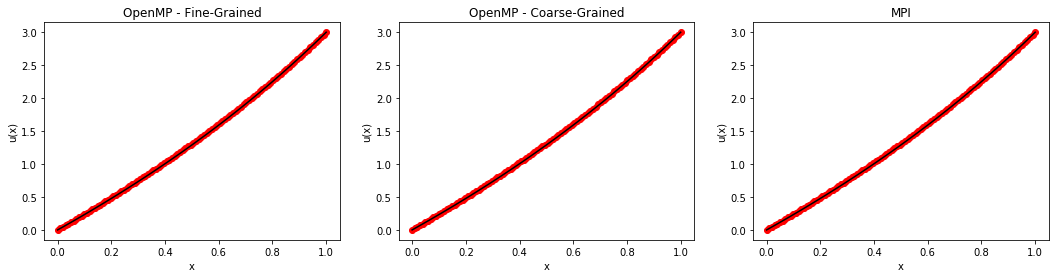

In [31]:
# Plotting code for each of the methods above
import os

import numpy
import matplotlib.pyplot as plt

u_true = lambda x: (4.0 - numpy.exp(1.0)) * x - 1.0 + numpy.exp(x)
x_fine = numpy.linspace(0.0, 1.0, 100)

base_path = "./src"
file_names = ["jacobi_omp1.txt", "jacobi_omp2.txt", "jacobi_mpi.txt"]
titles = ["OpenMP - Fine-Grained", "OpenMP - Coarse-Grained", "MPI"]
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 3)
for (i, title) in enumerate(titles):
    path = os.path.join(base_path, file_names[i])
    data = numpy.loadtxt(path)
    x = data[:, 0]
    U = data[:, 1]
    
    axes = fig.add_subplot(1, 3, i + 1)
    axes.plot(x, U, 'ro', label='computed')
    axes.plot(x_fine, u_true(x_fine), 'k', label="exact")
    axes.set_title(title)
    axes.set_xlabel('x')
    axes.set_ylabel('u(x)')

plt.show()

## Software Packages

### Linear Algebra
 - BLAS - Basic Lineag Algebra Subroutines
   - Level 1: Scalar and vector operations
   - Level 2: Matrix-vector operations
   - Level 3: Matrix-matrix operations
 - LAPACK - Linear Algebra Package
 - ScaLAPACK - Parallel LAPACK

### Solving ODEs
ODEPACK

### Solving PDEs